# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/data.csv')
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**

Исходя из общей информации мы видим, что в данных есть пропуски в столбцах days_employed и total_income, также даже исходя из первых 5 строчек мы видим что в столбце о стаже появляются аномальные значения превышающие срок жизни человека, а так же есть непонятки в части положительных\отрицательных значений. Однако мы видим что число пропусков у этих двух столбцов совпадает и имеет смысл проверить есть ли тут какая то закономерность. Если закономерности не будет, то для решения поставленных задач стаж людей нам не интересен, и я считаю что данный столбец можно удалить. 
Что касается дохода, этот столбец для решения задачи нам нужен, и пустые значения будет нужно заменить средним или медианным значением в зависимости от наличия в данных сильно выделяющихся значений.
Что касается причины пропущенных значений, исходя из столбца "стаж", поскольку в нем и положительные и отрицательные значения, предполагаю что это сводные данные из разных программ где он считается по разным алгоритмам.

## Шаг 2. Предобработка данных

### Обработка пропусков

In [2]:
data[data['days_employed'].isna()].tail(3)
#data[data['days_employed'].isna()&data['total_income'].isna()].count()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости
21510,2,NaN,28,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,приобретение автомобиля


Исходя из того что видим, можно сказать что пропущенные значения у стажа и дохода совпадают по строчкам. Можно сделать вывод что информация по данным клиентам бралась из источника где эти два типа данных не заполнялись. Однако в решении наших задач эта информация никак не поможет, остальные значения по этим строкам не имеют закономерностей, поэтому удаляем столбец стаж и приводим к среднему пропущенные значения дохода.

In [3]:
data = data.drop(['days_employed'], axis = 1)

In [4]:
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

In [5]:
#data[data['income_type'] == 'студент']
#data[data['income_type'] == 'безработный']
#data[data['income_type'] == 'в декрете']
#data[data['income_type'] == 'предприниматель'] #необходимо удалить строку, потому что делать среднее из одного значения будет некорректно.
data = data.drop(index = [5936])
#data.info()

In [6]:
#поскольку разница между min и max отличается в 10 раз, считаю что медиана больше подойдет для нашего исследования
median_income_gos = data[data['income_type'] == 'госслужащий']['total_income'].median() # 150448
median_income_pensioner = data[data['income_type'] == 'пенсионер']['total_income'].median() # 119514
median_income_companion = data[data['income_type'] == 'компаньон']['total_income'].median() # 172358
median_income_worker = data[data['income_type'] == 'сотрудник']['total_income'].median() # 142594

In [41]:
def change_zero(row):
    income_type = row['income_type']
    total_income = row['total_income']
    if income_type == 'госслужащий':
        if total_income == 'замена':
            return(median_income_gos)
    if income_type == 'пенсионер':
        if total_income == 'замена':
            return(median_income_pensioner)
    if income_type == 'сотрудник':
        if total_income == 'замена':
            return(median_income_worker)
    if income_type == 'компаньон':
        if total_income == 'замена':
            return(median_income_companion)
    return(total_income)
data['total_income'] = data['total_income'].fillna('замена')
data['total_income'] = data.apply(change_zero, axis = 1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 11 columns):
children            21524 non-null int64
dob_years           21524 non-null int64
education           21524 non-null object
education_id        21524 non-null int64
family_status       21524 non-null object
family_status_id    21524 non-null int64
gender              21524 non-null object
income_type         21524 non-null object
debt                21524 non-null int64
total_income        21524 non-null float64
purpose             21524 non-null object
dtypes: float64(1), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

Мы избавились от пропусков в нашей таблице. Приступим к замене типа данных.

### Замена типа данных

In [9]:
data['total_income'] = data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 11 columns):
children            21524 non-null int64
dob_years           21524 non-null int64
education           21524 non-null object
education_id        21524 non-null int64
family_status       21524 non-null object
family_status_id    21524 non-null int64
gender              21524 non-null object
income_type         21524 non-null object
debt                21524 non-null int64
total_income        21524 non-null int64
purpose             21524 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


**Вывод**

Мы заменили тип данных в столбце "доход", на целые числа с целью повышения точности при выборке до рубля.

### Обработка дубликатов

In [10]:
data.head(10)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


Итак, для того чтобы избавиться от дубликатов необходимо привести все данные таблицы в порядок, а для этого необходимо:
1) Проверить числовые данные на наличие артефактов и недопустимых значений. По возможности исправить их.

2) Привести в порядок стобцы с типом 'object'. Привести данные в один регистр, вид, классификацию (с помощью стемминга или лемматизации).

3) Применить методы по поиску и исключению дубликатов.

4) Вы великолепны.

In [11]:
#children
data['children'].value_counts()         # Видим что по данному столбцу сильно выделяются два значения: -1 и 20. Разберемся.

 0     14148
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [12]:
data[data['children'] == -1].head(5) # Видим что в остальном данные нормальные. 
#Поскольку отрицательного кол-ва детей быть не может, спишем это на особенность выгрузки и заменим значение на "1".

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816,профильное образование
705,-1,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882,приобретение автомобиля
742,-1,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268,дополнительное образование
800,-1,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293,дополнительное образование
941,-1,57,Среднее,1,женат / замужем,0,F,пенсионер,0,118514,на покупку своего автомобиля


In [13]:
data[data['children'] == 20].head(5)
#data[data['children'] == 20]['family_status'].value_counts()
#data['children'].median()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
606,20,21,среднее,1,женат / замужем,0,M,компаньон,0,145334,покупка жилья
720,20,44,среднее,1,женат / замужем,0,F,компаньон,0,112998,покупка недвижимости
1074,20,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518,получение образования
2510,20,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474,операции с коммерческой недвижимостью
2941,20,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739,на покупку автомобиля


Вижу 3 возможных объяснения:
1) Здесь должно стоять значение "0".

2) Здесь должно стоять значение "2".

3) Клиент дал заведомо ложную информацию, а 20 это максимальное допустимое значение в базе. (чтобы обмануть алгоритм и получить согласие банка на кредит? Можно дать обратную связь банку что если их алгоритм согласования кредитов дает преимущество при наличии большого кол-ва детей, то кто то это заметил и пользуется, в следствии чего банку необходимо пересмотреть алгоритм и добавить как минимум проверку по возрасту).

Закономерностей с данными других столбцов я не нашел.(прим. для ревьюера: я менял значения столбцов на все возможные, а не только 'family_status', просто не вижу смысла засорять проект кучей однотипных строчек).

Как итог, поскольку остальная часть данных в основном выглядит адекватно, для нашего исследования можно принять за кол-во детей медианное значение (равное нулю, что также является одним из вариантов значения которое должно быть), чтобы итоговые результаты не пострадали. К счастью таких клиентов у нас всего 0,3% от общего количества, поэтому качество выводов пострадать не должно. Ну и необходимо дать обратную связь банку конечно же.

In [14]:
data['children'] = data['children'].replace(-1, 1)
data['children'] = data['children'].replace(20, 0)
data['children'].value_counts()

0    14224
1     4865
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

In [15]:
#dob_years
mean_dob_years = data['dob_years'].mean().astype('int')

Очевидно что все люди берущие кредиты совершеннолетние, поэтому единственное артефактное значение "0" заменим за среднее, в данном случае разброс в возрасте не такой критичный и среднее нам подойдет больше медианы. Также категоризируем данные на 3 группы "молодежь" - от 18 до 35, "средний возраст" - от 36 до 64 лет, "пенсионер" - 65 и более, чтобы в будущем было проще проводить аналитику.

In [16]:
data['dob_years'] = data['dob_years'].replace(0, mean_dob_years)
def age_group(row):
    if row <= 35:
        return('молодежь')
    if row <= 64:
        return('средний возраст')
    return('пенсионер')

In [17]:
data['age_group'] = data['dob_years'].apply(age_group)
data.head(5)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,средний возраст
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,средний возраст
2,0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,молодежь
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,молодежь
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,средний возраст


In [18]:
#education_id
data['education_id'].value_counts()

1    15233
0     5259
2      744
3      282
4        6
Name: education_id, dtype: int64

In [19]:
#education
data['education'].value_counts()

среднее                13750
высшее                  4717
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

В столбце "идентификаторов образования" артефактов не найдено, но необходимо проверить на соответствие значений с столбцом "образование". В столбце "Образование" все значения имеют один вид, кроме высоты букв, поэтому мы просто превратим все буквы в строчные. Если количество значений сойдется, перейдем к следующим столбцам.

In [20]:
data['education'] = data['education'].str.lower()
data['education'].value_counts() # Значения сходятся

среднее                15233
высшее                  5259
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [21]:
#family_status
data['family_status'].value_counts() # С такими данными можно работать

женат / замужем          12379
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [22]:
#family_status_id
data['family_status_id'].value_counts() # Значения сходятся с предидущим столбцом, работаем дальше

0    12379
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

In [23]:
#gender
data[data['gender'] == 'XNA']

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
10701,0,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости,молодежь


В данном столбце есть один артефакт, но поскольку перед нами не стоит вопрос о влиянии пола на погашение кредита, можно закрыть на него глаза. В конце концов в трансгендерах нет ничего плохого. Если такой вопрос возникнет, нужно будет просто создать табличку где эта строка исключена.

In [24]:
#income_type
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
в декрете              1
предприниматель        1
студент                1
Name: income_type, dtype: int64

Тип дохода клиентов в данном исследовании нам тоже не особо принципиален. При необходимости исследования данных по месту получения дохода я бы просто убрал строки со значениями 2 и меньше, потому что они являются частными и не отразят реальную статистику. Столбец с доходом мы уже поправили, но для дальнейшего анализа нужно разделить его на категории.

In [25]:
#total_income
#data['total_income'].mean() #165550
#data['total_income'].median() #145017
#data['total_income'].max() #2265604
#data['total_income'].min() #20667

Для того чтобы разбить доходы клиентов на категории, необходимо понимать какое реальное среднее значение, я считаю что правильнее всего будет взять медианное значение за среднее (145000), и разделить на следующие категории:

1) Низкие (< 85к)

2) Ниже средних (85-125к)

3) Средние (125-165к)

4) Выше средних (165-205к)

5) Высокие (>200к)

In [26]:
def income_group(row):
    if row <= 85000:
        return('Низкие (< 85к)')
    if row <= 125000:
        return('Ниже средних (85-125к)')
    if row <= 165000:
        return('Средние (125-165к)')
    if row <= 205000:
        return('Выше средних (165-205к)')
    return('Высокие (>200к)')
data['income_group'] = data['total_income'].apply(income_group)
data.head(5)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,income_group
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,средний возраст,Высокие (>200к)
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,средний возраст,Ниже средних (85-125к)
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,молодежь,Средние (125-165к)
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,молодежь,Высокие (>200к)
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,средний возраст,Средние (125-165к)


In [27]:
#purpose
data = data.drop_duplicates().reset_index(drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21453 entries, 0 to 21452
Data columns (total 13 columns):
children            21453 non-null int64
dob_years           21453 non-null int64
education           21453 non-null object
education_id        21453 non-null int64
family_status       21453 non-null object
family_status_id    21453 non-null int64
gender              21453 non-null object
income_type         21453 non-null object
debt                21453 non-null int64
total_income        21453 non-null int64
purpose             21453 non-null object
age_group           21453 non-null object
income_group        21453 non-null object
dtypes: int64(6), object(7)
memory usage: 2.1+ MB


**Вывод**

На данный момент мы привели в порядок все столбцы кроме цели кредита, но даже это уже позволило нам избавится от 71 дубликата. Далее необходимо привести в порядок столбец цели кредита через леммизацию и приведению к 4 основным категориям: 1) недвижимость 2) автомобиль 3) свадьба 4) образование. Возможно после замены значений в этом столбце мы сможем избавиться от еще большего числа дубликатов.

### Лемматизация

In [28]:
from pymystem3 import Mystem
m = Mystem() 
def lemmatizing(row):
    try:
        lemma = m.lemmatize(row)
        return(lemma)
    except:
        return('error')
data_lemma = data['purpose'].apply(lemmatizing)
data_lemma.head(5)

0                 [покупка,  , жилье, \n]
1       [приобретение,  , автомобиль, \n]
2                 [покупка,  , жилье, \n]
3    [дополнительный,  , образование, \n]
4               [сыграть,  , свадьба, \n]
Name: purpose, dtype: object

In [29]:
from collections import Counter
lemm_spisok = []
purpose = data['purpose']
for element in purpose:
    lemm_spisok.extend(m.lemmatize(element))
Counter(lemm_spisok)
#data['lemmas'][2]
#stop_word1 = ['жилье']
#''.join(filter(lambda s: s in stop_word1, data['lemmas'][2]))
#data.lemmas.str.contains('жилье')

Counter({'покупка': 5896,
         ' ': 33568,
         'жилье': 4460,
         '\n': 21453,
         'приобретение': 461,
         'автомобиль': 4306,
         'дополнительный': 906,
         'образование': 4013,
         'сыграть': 765,
         'свадьба': 2324,
         'операция': 2604,
         'с': 2918,
         'на': 2222,
         'проведение': 768,
         'для': 1289,
         'семья': 638,
         'недвижимость': 6350,
         'коммерческий': 1311,
         'жилой': 1229,
         'строительство': 1878,
         'собственный': 635,
         'подержать': 478,
         'свой': 2230,
         'со': 627,
         'заниматься': 904,
         'сделка': 941,
         'подержанный': 486,
         'получение': 1314,
         'высокий': 1374,
         'профильный': 436,
         'сдача': 651,
         'ремонт': 607})

**Вывод**

После проведения лемматизации, мы видим что в категорию "недвижимость" необходимо включить строки включающие в себя леммы "жилье", "жилой" и "недвижимость"; а в категории "автомобиль", "свадьба" и "образование", строки с аналогичными леммами.

### Категоризация данных

In [30]:
def category(row):
    try:
        if 'жилье' in row:
            return('недвижимость')
        if 'недвижимость' in row:
            return('недвижимость')
        if 'жилое' in row:
            return('недвижимость')
        if 'автомобиль' in row:
            return('автомобиль')
        if 'свадьба' in row:
            return('свадьба')
        if 'образование' in row:
            return('образование')
    except:
        return('error')
#data_lemma.apply(category).value_counts() # проверим все ли значения определились в категории
data['category_purpose'] = data_lemma.apply(category)
#data.info() #проверка

Поскольку цели кредита у нас категоризированы, столбец "purpose" нам уже не нужен и можно его удалить чтобы провести более точный поиск по дубликатам.

In [31]:
data = data.drop(['purpose'], axis = 1)

In [32]:
#data.duplicated().sum() # а вот и еще 339 строк на удаление
data = data.drop_duplicates().reset_index(drop = True)
data.shape

(21114, 13)

**Вывод**

Мы закончили с предобработкой данных, избавились от всех дупликатов, пропущенных значений и артефактов которые могли бы помешать нам найти ответы на поставленные вопросы. Теперь можно приступить к исследованию данных с учетом поставленных задач.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [33]:
pivot_data_children_debt = data.pivot_table(columns='children', values='debt')
pivot_data_children_debt

children,0,1,2,3,4,5
debt,0.076906,0.092766,0.095145,0.082067,0.1,0.0


In [34]:
sum_debt = data['debt'].sum() 
sum_clients = len(data['debt'])
percent_debt = sum_debt / sum_clients
percent_debt #получим процент клиентов которые не оплачивают кредиты вовремя из общего кол-ва

0.0823624135644596

**Вывод**

Как нам показывает таблица с данными, клиентам без детей как правило проще оплачивать кредиты в срок чем клиентам с одним ребенком, разница между ними составляет 1,6%, а также на 1,8% по сравнению с клиентами у которых два ребенка. 

Однако также по таблице видно что, клиенты у которых трое и более детей начинают относятся к вопросу финансов более ответственно, процент просрочек начинает уменьшаться. Клиентов с четырьмя и пятью детьми, в выборке не так много, поэтому данные по ним не показательны, но даже если мы возьмем по ним среднее, получится что то около 8% что является лучшим показателем чем у клиентов с одним или двумя детьми.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

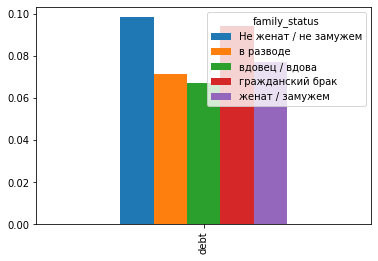

In [35]:
pivot_data_family_status_debt = data.pivot_table(columns='family_status', values='debt')
pivot_data_family_status_debt.plot(kind="bar")

**Вывод**

Исходя из графиков мы видим, что люди которые не оформляют свои отношения официально, более склонны к просрочке кредитов, по сравнению с теми, кто был женат. Разница составляет порядка 2-3%.   

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

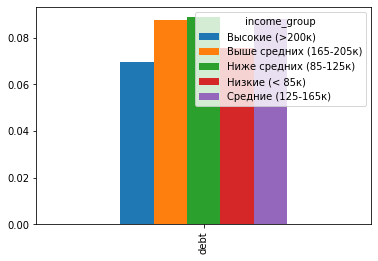

In [36]:
pivot_data_income_group_debt = data.pivot_table(columns='income_group', values='debt')
pivot_data_income_group_debt.plot(kind="bar")

**Вывод**

Люди с самыми низкими и с самыми высокими доходами являются более ответственными в плане своевременного погашения кредитов, чем люди, доход которых в нашей базе данных приближен к среднему на 1,5-2%. 

Это можно объяснить тем что люди с низкими доходами должны более точно планировать траты, чтобы хватало на жизнь, а для людей с высокими доходами выплата кредитов не составляет проблему, в то время как люди со средними доходами могут позволить себе не следить за тратами, но периодически не укладываться в свой бюджет.

- Как разные цели кредита влияют на его возврат в срок?

In [37]:
pivot_data_purpose_debt = data.pivot_table(columns='category_purpose', values='debt')
pivot_data_purpose_debt

category_purpose,автомобиль,недвижимость,образование,свадьба
debt,0.094101,0.073874,0.09334,0.080659


**Вывод**

Меньше всего просрочек происходит по кредитам связанным с недвижимостью, на втором месте идут свадьбы, и больше всего просрочек происходит по кредитам на автомобили и образование. 

На основании этого можно сделать вывод, что чем больше сумма кредита, тем с большей вероятностью он будет погашен без просрочек. Возможно именно поэтому банки не любят давать кредиты на маленькие суммы, а ипотеки одобряют большинству.

## Шаг 4. Общий вывод

Мы провели анализ данных кредитного отдела банка, и сделали выводы: 

1) что наиболее ответственно к вопросу погашения кредитов относятся женатые клиенты без детей

2) люди со средним доходом более склонны к просрочкам

3) чем больше сумма кредита тем больше вероятность его своевременного погашения

4) необходимо проверить алгоритмы кредитного отдела, на ошибки в одобрении кредитов при высоком кол-ве детей